In [32]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import datetime as dt


warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

In [3]:
yellow_19_20_sdf_agg = spark.read.parquet('../data/curated/yellow_19-20_agg/', header=True)
yellow_21_22_sdf_agg = spark.read.parquet('../data/curated/yellow_21-22_agg/', header=True)
fhvhv_19_20_sdf_agg = spark.read.parquet('../data/curated/fhvhv_19-20_agg/', header=True)
fhvhv_21_22_sdf_agg = spark.read.parquet('../data/curated/fhvhv_21-22_agg/', header=True)

yellow_21_22_sdf_agg_covid = spark.read.parquet('../data/curated/yellow_21-22_agg_covid/', header=True)
fhvhv_21_22_sdf_agg_covid = spark.read.parquet('../data/curated/fhvhv_21-22_agg_covid/', header=True)


In [27]:
yellow_21_22_df_agg_covid = yellow_21_22_sdf_agg_covid.toPandas()
fhvhv_21_22_df_agg_covid = fhvhv_21_22_sdf_agg_covid.toPandas()
yellow_19_20_df_agg = yellow_19_20_sdf_agg.toPandas()
yellow_21_22_df_agg = yellow_21_22_sdf_agg.toPandas()

In [5]:
def plot(model):
    fig, axes = plt.subplots(nrows=2, ncols=2)

    # residual vs fitted plot
    sns.scatterplot(model.fittedvalues, model.resid, ax=axes[0, 0])
    axes[0, 0].axhline(y=0, color='red', linestyle='dashed')
    axes[0, 0].set_title('Residuals vs Fitted')

    # qq plot
    sm.qqplot(model.resid, ax=axes[0, 1], line='r')
    axes[0, 1].set_title('Normal Q-Q')

    # scale-location plot
    sns.scatterplot(model.fittedvalues, model.resid_pearson, ax=axes[1, 0])
    axes[1, 0].set_title('Scale-Location')

    # standardised residuals vs leverage
    sns.scatterplot(model.get_influence().hat_matrix_diag, model.resid_pearson, ax=axes[1, 1])
    axes[1, 1].axhline(y=0, color='red', linestyle='dashed')
    axes[1, 1].set_title('Standardised Residuals vs Leverage')

    plt.tight_layout()
    plt.show()

<h2><u>Model 1</u></h2>

In [20]:
def model1_train_predict(df_agg_covid):
    columns = ['trip_count', 'CASE_COUNT', 'HOSPITALIZED_COUNT']
    model_df = df_agg_covid.loc[:, columns]

    train_data, test_data = train_test_split(model_df, test_size=0.3, random_state=42)

    baseline = smf.ols(formula='trip_count ~ 1', data=train_data).fit()
    baseline_pred = baseline.predict(test_data)
    baseline_RMSE = mean_squared_error(test_data['trip_count'], baseline_pred, squared=False)
    baseline_r2 = r2_score(test_data['trip_count'], baseline_pred)

    model = smf.ols("trip_count ~ CASE_COUNT + HOSPITALIZED_COUNT", data=train_data).fit()
    model_pred = model.predict(test_data)
    model_RMSE = mean_squared_error(test_data['trip_count'], model_pred, squared=False)
    model_r2 = r2_score(test_data['trip_count'], model_pred)

    print('Baseline RMSE: ', baseline_RMSE)
    print('Baseline R2: ', baseline_r2)
    print('')
    print('Model RMSE: ', model_RMSE)
    print('Model R2: ', model_r2)

    return model


**Yellow Taxi**

Baseline RMSE:  20315.164032040055
Baseline R2:  -0.04909056727574801

Model RMSE:  17258.49931349432
Model R2:  0.24285619248793777


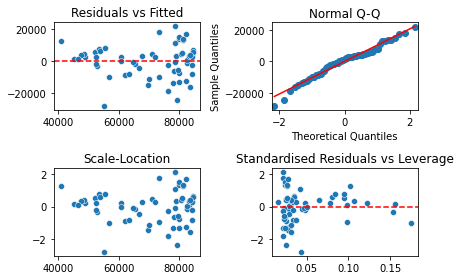

In [23]:
yellow_model1 = model1_train_predict(yellow_21_22_df_agg_covid)
plot(yellow_model1)

**HVFHV**

Baseline RMSE:  100663.4764489661
Baseline R2:  -0.06028756119278489

Model RMSE:  73022.0144519997
Model R2:  0.44206007968288685


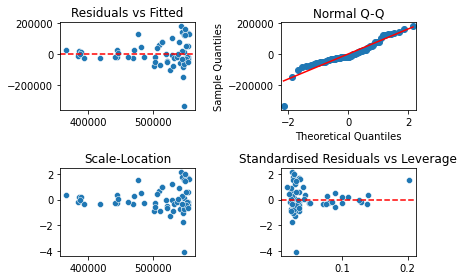

In [25]:
hvfhv_model1 = model1_train_predict(fhvhv_21_22_df_agg_covid)
plot(hvfhv_model1)

<h2><u>Model 2</u></h2>

Model RMSE:  0.13815861705889793
Model R2:  0.9894500091866376


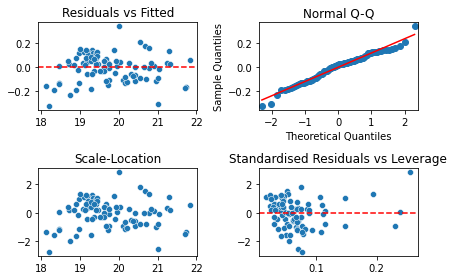

In [80]:
def model2(df_19_20, df_21_22):  
    train_data = df_19_20.copy()
    train_data['date'] = train_data['date'].map(dt.datetime.toordinal)

    test_data = df_21_22.copy()
    test_data['date'] = test_data['date'].map(dt.datetime.toordinal)
    
    columns = "+".join(train_data.columns.difference(['total_amount_avg']))
    model = smf.ols("total_amount_avg ~" + columns, data=train_data).fit()

    model_pred = model.predict(test_data)
    model_RMSE = mean_squared_error(test_data['total_amount_avg'], model_pred, squared=False)
    model_r2 = r2_score(test_data['total_amount_avg'], model_pred)

    print('Model RMSE: ', model_RMSE)
    print('Model R2: ', model_r2)

    return model

yellow_model2 = model2(yellow_19_20_df_agg, yellow_21_22_df_agg)
plot(yellow_model2)